In [4]:
from sklearn.datasets import fetch_20newsgroups

# Cargar el corpus de noticias sin cabeceras, pies de página y citas
newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
newsgroupsdocs = newsgroups.data

In [8]:
# Parte 1: Cálculo de TF, DF, IDF y TF-IDF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd
import numpy as np

# --- TF (Term Frequency) ---
count_vectorizer = CountVectorizer(max_features=15, stop_words='english')  # limitamos a 15 términos más frecuentes
X_counts = count_vectorizer.fit_transform(newsgroupsdocs)

# Crear DataFrame con la matriz TF
tf_df = pd.DataFrame(X_counts.toarray(), columns=count_vectorizer.get_feature_names_out())
print("Matriz TF (Frecuencia de Términos)")
print(tf_df.head())

# DF (Document Frequency)
# Cantidad de documentos donde aparece cada término
df_values = np.sum(X_counts.toarray() > 0, axis=0)
df_df = pd.DataFrame({'término': count_vectorizer.get_feature_names_out(), 'DF': df_values})
print("\nFrecuencia de Documentos (DF)")
print(df_df)

# --- TF-IDF ---
tfidf_vectorizer = TfidfVectorizer(max_features=15, stop_words='english')
X_tfidf = tfidf_vectorizer.fit_transform(newsgroupsdocs)

# Crear DataFrame con la matriz TF-IDF
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

print("\nMatriz TF-IDF")
print(tfidf_df.head())

# --- Comparación de valores ---
summary = pd.DataFrame({
    'Término': tfidf_vectorizer.get_feature_names_out(),
    'DF': df_values,
    'TF Promedio': tf_df.mean(axis=0).values,
    'TF-IDF Promedio': tfidf_df.mean(axis=0).values
})

print("\nComparación de TF, DF y TF-IDF Promedio")
print(summary.sort_values(by='TF-IDF Promedio', ascending=False))


Matriz TF (Frecuencia de Términos)
   ax  does  don  edu  god  good  just  know  like  max  new  people  think  \
0   0     0    0    0    0     0     1     0     0    0    0       0      0   
1   0     1    0    0    0     0     0     0     0    0    0       0      0   
2   0     0    2    0    0     0     0     1     2    0    1       0      0   
3   0     0    0    0    0     0     0     0     0    0    0       0      1   
4   0     1    0    0    0     0     0     2     0    0    1       0      0   

   time  use  
0     0    0  
1     0    0  
2     1    0  
3     1    0  
4     0    3  

Frecuencia de Documentos (DF)
   término    DF
0       ax    22
1     does  2988
2      don  3894
3      edu  1560
4      god   947
5     good  2558
6     just  4081
7     know  3799
8     like  4212
9      max   114
10     new  2241
11  people  2988
12   think  3144
13    time  2949
14     use  2705

Matriz TF-IDF
    ax     does       don  edu  god  good  just      know     like  max  \
0  0.0 

In [16]:
# Parte 2: Ranking de documentos usando TF-IDF

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import matplotlib.pyplot as plt

# Paso 2: Cargar el corpus
newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
docs = newsgroups.data  # lista de documentos

# Paso 3: Crear el modelo TF-IDF para el corpus
vectorizer = TfidfVectorizer(stop_words='english')
X_tfidf = vectorizer.fit_transform(docs)

# Paso 4: Definir una consulta
consulta = "good"

# Paso 5: Construir el vector de consulta con el mismo modelo
consulta_tfidf = vectorizer.transform([consulta])

# Paso 6: Calcular la similitud coseno entre la consulta y todos los documentos
similaridades = cosine_similarity(consulta_tfidf, X_tfidf).flatten()

# Paso 7: Crear un DataFrame con las similitudes
ranking = pd.DataFrame({
    'Documento': range(len(docs)),
    'Similitud_Coseno': similaridades
})

# Paso 8: Ordenar los documentos por relevancia (mayor similitud primero)
ranking = ranking.sort_values(by='Similitud_Coseno', ascending=False).reset_index(drop=True)

# Paso 9: Mostrar los 10 documentos más relevantes
top10 = ranking.head(10)

# Paso 10: Mostrar los resultados en una tabla
print("Ranking de los 10 documentos más relevantes para la consulta:")
print(top10)




Ranking de los 10 documentos más relevantes para la consulta:
   Documento  Similitud_Coseno
0       6665          1.000000
1       6509          0.486889
2       2361          0.407018
3      18502          0.393848
4       2950          0.307906
5      17361          0.303181
6       2427          0.298025
7       8946          0.274450
8       7065          0.274332
9      17592          0.270053


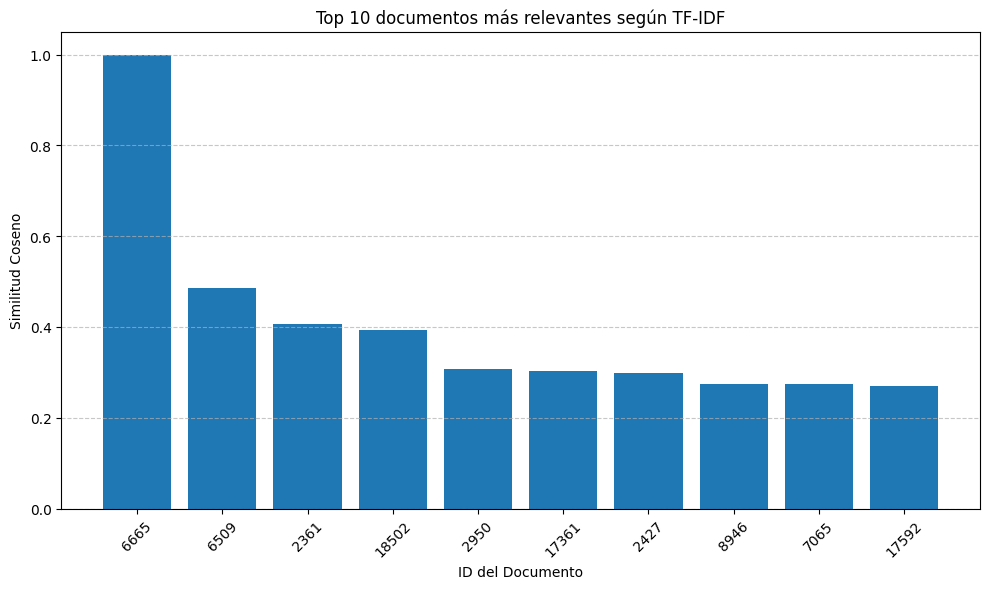

In [15]:

import matplotlib.pyplot as plt
#Visualizar los scores con un gráfico de barras

plt.figure(figsize=(10, 6))
plt.bar(top10['Documento'].astype(str), top10['Similitud_Coseno'])
plt.title('Top 10 documentos más relevantes según TF-IDF')
plt.xlabel('ID del Documento')
plt.ylabel('Similitud Coseno')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [17]:

# Evaluación: Precision@3 y MAP

relevantes = set(top10['Documento'].head(5))

#  Calcular Precision@3
top3 = ranking.head(3)
relevantes_en_top3 = sum([1 for d in top3['Documento'] if d in relevantes])
precision_at_3 = relevantes_en_top3 / 3

# Calcular MAP (Mean Average Precision)
def average_precision(ranking, relevantes):
    precision_acumulada = 0
    relevantes_encontrados = 0

    for i, doc_id in enumerate(ranking['Documento'], start=1):
        if doc_id in relevantes:
            relevantes_encontrados += 1
            precision_acumulada += relevantes_encontrados / i

    if len(relevantes) == 0:
        return 0
    return precision_acumulada / len(relevantes)

map_score = average_precision(ranking.head(10), relevantes)

# Mostrar resultados
print(f"\nPrecision@3: {precision_at_3:.4f}")
print(f"MAP (Mean Average Precision): {map_score:.4f}")



Precision@3: 1.0000
MAP (Mean Average Precision): 1.0000
